<a href="https://www.bigdatauniversity.com"><img src="https://ibm.box.com/shared/static/cw2c7r3o20w9zn8gkecaeyjhgw3xdgbj.png" width="400" align="center"></a>

<h1 align="center"><font size="5">Classification with Python</font></h1>

In this notebook we try to practice all the classification algorithms that we learned in this course.

We load a dataset using Pandas library, and apply the following algorithms, and find the best one for this specific dataset by accuracy evaluation methods.

Lets first load required libraries:

In [1]:
import itertools
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import NullFormatter
import pandas as pd
import numpy as np
import matplotlib.ticker as ticker
from sklearn import preprocessing
%matplotlib inline

### About dataset

This dataset is about past loans. The __Loan_train.csv__ data set includes details of 346 customers whose loan are already paid off or defaulted. It includes following fields:

| Field          | Description                                                                           |
|----------------|---------------------------------------------------------------------------------------|
| Loan_status    | Whether a loan is paid off on in collection                                           |
| Principal      | Basic principal loan amount at the                                                    |
| Terms          | Origination terms which can be weekly (7 days), biweekly, and monthly payoff schedule |
| Effective_date | When the loan got originated and took effects                                         |
| Due_date       | Since it’s one-time payoff schedule, each loan has one single due date                |
| Age            | Age of applicant                                                                      |
| Education      | Education of applicant                                                                |
| Gender         | The gender of applicant                                                               |

Lets download the dataset

In [2]:
!wget -O loan_train.csv https://s3-api.us-geo.objectstorage.softlayer.net/cf-courses-data/CognitiveClass/ML0101ENv3/labs/loan_train.csv

--2019-05-23 23:50:46--  https://s3-api.us-geo.objectstorage.softlayer.net/cf-courses-data/CognitiveClass/ML0101ENv3/labs/loan_train.csv
Resolving s3-api.us-geo.objectstorage.softlayer.net (s3-api.us-geo.objectstorage.softlayer.net)... 67.228.254.193
Connecting to s3-api.us-geo.objectstorage.softlayer.net (s3-api.us-geo.objectstorage.softlayer.net)|67.228.254.193|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 23101 (23K) [text/csv]
Saving to: ‘loan_train.csv’

100%[======================================>] 23,101      --.-K/s   in 0.002s  

2019-05-23 23:50:46 (12.7 MB/s) - ‘loan_train.csv’ saved [23101/23101]



### Load Data From CSV File  

In [298]:
df = pd.read_csv('loan_train.csv')
df.head()

,Unnamed: 0,Unnamed: 0.1,loan_status,Principal,terms,effective_date,due_date,age,education,Gender
0,0,0,PAIDOFF,1000,30,9/8/2016,10/7/2016,45,High School or Below,male
1,2,2,PAIDOFF,1000,30,9/8/2016,10/7/2016,33,Bechalor,female
2,3,3,PAIDOFF,1000,15,9/8/2016,9/22/2016,27,college,male
3,4,4,PAIDOFF,1000,30,9/9/2016,10/8/2016,28,college,female
4,6,6,PAIDOFF,1000,30,9/9/2016,10/8/2016,29,college,male


In [299]:
df.shape

(346, 10)

### Convert to date time object 

In [300]:
df['due_date'] = pd.to_datetime(df['due_date'])
df['effective_date'] = pd.to_datetime(df['effective_date'])
df.head()

,Unnamed: 0,Unnamed: 0.1,loan_status,Principal,terms,effective_date,due_date,age,education,Gender
0,0,0,PAIDOFF,1000,30,2016-09-08,2016-10-07,45,High School or Below,male
1,2,2,PAIDOFF,1000,30,2016-09-08,2016-10-07,33,Bechalor,female
2,3,3,PAIDOFF,1000,15,2016-09-08,2016-09-22,27,college,male
3,4,4,PAIDOFF,1000,30,2016-09-09,2016-10-08,28,college,female
4,6,6,PAIDOFF,1000,30,2016-09-09,2016-10-08,29,college,male


# Data visualization and pre-processing



Let’s see how many of each class is in our data set 

In [301]:
df['loan_status'].value_counts()

PAIDOFF       260
COLLECTION     86
Name: loan_status, dtype: int64

260 people have paid off the loan on time while 86 have gone into collection 


Lets plot some columns to underestand data better:

In [7]:
# notice: installing seaborn might takes a few minutes
!conda install -c anaconda seaborn -y

Solving environment: done

## Package Plan ##

  environment location: /opt/conda/envs/DSX-Python35

  added / updated specs: 
    - seaborn


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    ca-certificates-2019.1.23  |                0         126 KB  anaconda
    certifi-2018.8.24          |           py35_1         139 KB  anaconda
    seaborn-0.9.0              |           py35_0         378 KB  anaconda
    openssl-1.0.2r             |       h7b6447c_0         3.2 MB  anaconda
    ------------------------------------------------------------
                                           Total:         3.8 MB

The following packages will be UPDATED:

    ca-certificates: 2019.1.23-0          --> 2019.1.23-0       anaconda
    certifi:         2018.8.24-py35_1     --> 2018.8.24-py35_1  anaconda
    openssl:         1.0.2r-h7b6447c_0    --> 1.0.2r-h7b6447c_0 anaconda
    seaborn:         0

In [302]:
# Just a quick check without pandas as I'm not very used-to pandas
female_default = np.where((df['Gender']=='female') & (df['loan_status']=='COLLECTION'))[0]
female = np.where((df['Gender']=='female'))[0]
male_default = np.where((df['Gender']=='male') & (df['loan_status']=='COLLECTION'))[0]
male = np.where((df['Gender']=='male'))[0]
print ('Fraction of Female defaulters =', len(female_default)/len(female))
print ('Fraction of male defaulters =', len(male_default)/len(male))

Fraction of Female defaulters = 0.1346153846153846
Fraction of male defaulters = 0.2687074829931973


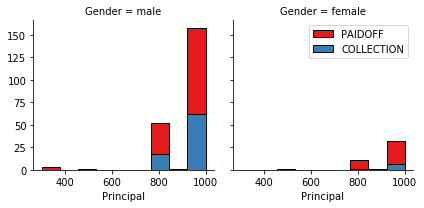

In [303]:
import seaborn as sns

bins = np.linspace(df.Principal.min(), df.Principal.max(), 10)
g = sns.FacetGrid(df, col="Gender", hue="loan_status", palette="Set1", col_wrap=2)
g.map(plt.hist, 'Principal', bins=bins, ec="k")

g.axes[-1].legend()
plt.show()

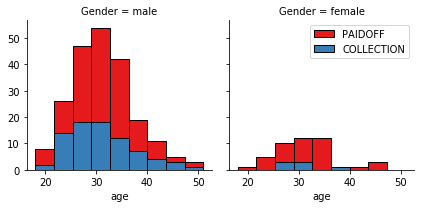

In [304]:
bins = np.linspace(df.age.min(), df.age.max(), 10)
g = sns.FacetGrid(df, col="Gender", hue="loan_status", palette="Set1", col_wrap=2)
g.map(plt.hist, 'age', bins=bins, ec="k")

g.axes[-1].legend()
plt.show()

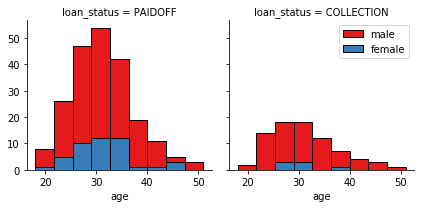

In [305]:
bins = np.linspace(df.age.min(), df.age.max(), 10)
g = sns.FacetGrid(df, col="loan_status", hue="Gender", palette="Set1", col_wrap=2)
g.map(plt.hist, 'age', bins=bins, ec="k")

g.axes[-1].legend()
plt.show()

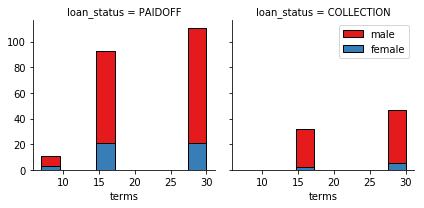

In [306]:
bins = np.linspace(df.terms.min(), df.terms.max(), 10)
g = sns.FacetGrid(df, col="loan_status", hue="Gender", palette="Set1", col_wrap=2)
g.map(plt.hist, 'terms', bins=bins, ec="k")

g.axes[-1].legend()
plt.show()
# There is no actual correlation with the terms.

# Pre-processing:  Feature selection/extraction

### Lets look at the day of the week people get the loan 

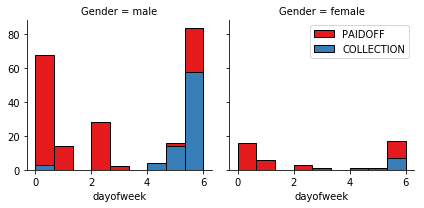

In [307]:
df['dayofweek'] = df['effective_date'].dt.dayofweek
bins = np.linspace(df.dayofweek.min(), df.dayofweek.max(), 10)
g = sns.FacetGrid(df, col="Gender", hue="loan_status", palette="Set1", col_wrap=2)
g.map(plt.hist, 'dayofweek', bins=bins, ec="k")
g.axes[-1].legend()
plt.show()


We see that people who get the loan at the end of the week dont pay it off, so lets use Feature binarization to set a threshold values less then day 4 

In [308]:
df['weekend'] = df['dayofweek'].apply(lambda x: 1 if (x>3)  else 0)
df.head()

,Unnamed: 0,Unnamed: 0.1,loan_status,Principal,terms,effective_date,due_date,age,education,Gender,dayofweek,weekend
0,0,0,PAIDOFF,1000,30,2016-09-08,2016-10-07,45,High School or Below,male,3,0
1,2,2,PAIDOFF,1000,30,2016-09-08,2016-10-07,33,Bechalor,female,3,0
2,3,3,PAIDOFF,1000,15,2016-09-08,2016-09-22,27,college,male,3,0
3,4,4,PAIDOFF,1000,30,2016-09-09,2016-10-08,28,college,female,4,1
4,6,6,PAIDOFF,1000,30,2016-09-09,2016-10-08,29,college,male,4,1


## Convert Categorical features to numerical values

Lets look at gender:

In [309]:
df.groupby(['Gender'])['loan_status'].value_counts(normalize=True)

Gender  loan_status
female  PAIDOFF        0.865385
        COLLECTION     0.134615
male    PAIDOFF        0.731293
        COLLECTION     0.268707
Name: loan_status, dtype: float64

86 % of female pay there loans while only 73 % of males pay there loan


Lets convert male to 0 and female to 1:


In [310]:
df['Gender'].replace(to_replace=['male','female'], value=[0,1],inplace=True)
df.head()

,Unnamed: 0,Unnamed: 0.1,loan_status,Principal,terms,effective_date,due_date,age,education,Gender,dayofweek,weekend
0,0,0,PAIDOFF,1000,30,2016-09-08,2016-10-07,45,High School or Below,0,3,0
1,2,2,PAIDOFF,1000,30,2016-09-08,2016-10-07,33,Bechalor,1,3,0
2,3,3,PAIDOFF,1000,15,2016-09-08,2016-09-22,27,college,0,3,0
3,4,4,PAIDOFF,1000,30,2016-09-09,2016-10-08,28,college,1,4,1
4,6,6,PAIDOFF,1000,30,2016-09-09,2016-10-08,29,college,0,4,1


## One Hot Encoding  
#### How about education?

In [311]:
df.groupby(['education'])['loan_status'].value_counts(normalize=True)

education             loan_status
Bechalor              PAIDOFF        0.750000
                      COLLECTION     0.250000
High School or Below  PAIDOFF        0.741722
                      COLLECTION     0.258278
Master or Above       COLLECTION     0.500000
                      PAIDOFF        0.500000
college               PAIDOFF        0.765101
                      COLLECTION     0.234899
Name: loan_status, dtype: float64

#### Feature befor One Hot Encoding

In [312]:
df[['Principal','terms','age','Gender','education']].head()

,Principal,terms,age,Gender,education
0,1000,30,45,0,High School or Below
1,1000,30,33,1,Bechalor
2,1000,15,27,0,college
3,1000,30,28,1,college
4,1000,30,29,0,college


#### Use one hot encoding technique to conver categorical varables to binary variables and append them to the feature Data Frame 

In [313]:
Feature = df[['Principal','terms','age','Gender','weekend']]
Feature = pd.concat([Feature,pd.get_dummies(df['education'])], axis=1)
Feature.drop(['Master or Above'], axis = 1,inplace=True)  # As there are just two people with masters (see by changing normalizing to False above)
Feature.head()


,Principal,terms,age,Gender,weekend,Bechalor,High School or Below,college
0,1000,30,45,0,0,0,1,0
1,1000,30,33,1,0,1,0,0
2,1000,15,27,0,0,0,0,1
3,1000,30,28,1,1,0,0,1
4,1000,30,29,0,1,0,0,1


### Feature selection

Lets defind feature sets, X:

In [314]:
X = Feature
X[0:5]

,Principal,terms,age,Gender,weekend,Bechalor,High School or Below,college
0,1000,30,45,0,0,0,1,0
1,1000,30,33,1,0,1,0,0
2,1000,15,27,0,0,0,0,1
3,1000,30,28,1,1,0,0,1
4,1000,30,29,0,1,0,0,1


What are our lables?

In [315]:
y = df['loan_status'].values
y[0:5]

array(['PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF'], dtype=object)

## Normalize Data 

Data Standardization give data zero mean and unit variance (technically should be done after train test split )

In [316]:
X= preprocessing.StandardScaler().fit(X).transform(X)
X[0:5]

array([[ 0.52,  0.92,  2.33, -0.42, -1.21, -0.38,  1.14, -0.87],
       [ 0.52,  0.92,  0.34,  2.38, -1.21,  2.62, -0.88, -0.87],
       [ 0.52, -0.96, -0.65, -0.42, -1.21, -0.38, -0.88,  1.15],
       [ 0.52,  0.92, -0.49,  2.38,  0.83, -0.38, -0.88,  1.15],
       [ 0.52,  0.92, -0.32, -0.42,  0.83, -0.38, -0.88,  1.15]])

# Classification 

Now, it is your turn, use the training set to build an accurate model. Then use the test set to report the accuracy of the model
You should use the following algorithm:
- K Nearest Neighbor(KNN)
- Decision Tree
- Support Vector Machine
- Logistic Regression



__ Notice:__ 
- You can go above and change the pre-processing, feature selection, feature-extraction, and so on, to make a better model.
- You should use either scikit-learn, Scipy or Numpy libraries for developing the classification algorithms.
- You should include the code of the algorithm in the following cells.

# K Nearest Neighbor(KNN)
Notice: You should find the best k to build the model with the best accuracy.  
**warning:** You should not use the __loan_test.csv__ for finding the best k, however, you can split your train_loan.csv into train and test to find the best __k__.

In [317]:
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn import metrics
from sklearn.metrics import jaccard_similarity_score
X_train, X_test, y_train, y_test = train_test_split( X, y, test_size=0.2, random_state=4)
print ('Train set:', X_train.shape,  y_train.shape)
print ('Test set:', X_test.shape,  y_test.shape)

Train set: (276, 8) (276,)
Test set: (70, 8) (70,)


In [318]:
# Number of nearest neighbours 
k = 5
#Train Model and Predict  
neigh = KNeighborsClassifier(n_neighbors = k).fit(X_train,y_train)
print("Train set Accuracy: ", metrics.accuracy_score(y_train, neigh.predict(X_train)))
print("Test set Accuracy: ", metrics.accuracy_score(y_test, neigh.predict(X_test)))

Train set Accuracy:  0.815217391304
Test set Accuracy:  0.757142857143


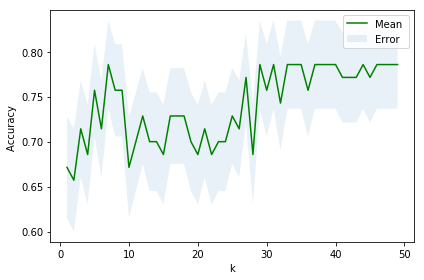

It seems that best accuracy is 0.785714285714 with k= 7


In [319]:
# Test now which value of K is optimum
Ks = 50
mean_acc = np.zeros((Ks-1))
std_acc = np.zeros((Ks-1))
for n in range(1,Ks):
    #Train Model and Predict  
    neigh = KNeighborsClassifier(n_neighbors = n).fit(X_train,y_train)
    y_test_prediction = neigh.predict(X_test)
    mean_acc[n-1] = metrics.accuracy_score(y_test, y_test_prediction)
    std_acc[n-1]=np.std(y_test_prediction==y_test)/np.sqrt(y_test_prediction.shape[0])

# Plot to see how accuracy varies with k
plt.plot(range(1,Ks),mean_acc,'g')
plt.fill_between(range(1,Ks),mean_acc - 1 * std_acc,mean_acc + 1 * std_acc, alpha=0.10)
plt.legend(('Mean ', 'Error'))
plt.ylabel('Accuracy ')
plt.xlabel('k')
plt.tight_layout()
plt.show()

print( "It seems that best accuracy is", mean_acc.max(), "with k=", mean_acc.argmax()+1)

Jaccard Similarity Score (k = 7) = 0.785714285714


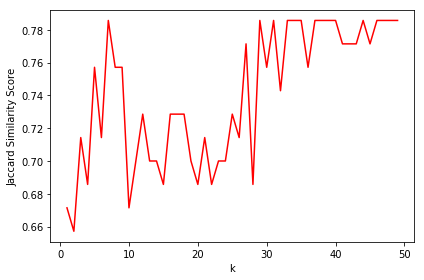

Jaccard Similarity Score is maximum at  7 with score= 0.785714285714


In [320]:
# Although it seems that the best accuracy is when k=7 
# i.e. when we let the algorithm to fin 7 nearest neighbours but the plot also shows high accuracy at higher k
# However, this seems implausible. I will check this using Jaccard similarity score and confusion matrix

# Jaccard Similarity Score:
k = mean_acc.argmax()+1 # Optimal value 
#Train Model and Predict  
neigh = KNeighborsClassifier(n_neighbors = k).fit(X_train,y_train)
y_test_predict = neigh.predict(X_test)
print ('Jaccard Similarity Score (k = 7) =', jaccard_similarity_score(y_test, y_test_predict))

#Let's try few nearest neighbour values
Ks = 50
jac_similarity = np.zeros((Ks-1))
for n in range(1,Ks):
    neigh = KNeighborsClassifier(n_neighbors = n).fit(X_train,y_train)
    y_test_predict = neigh.predict(X_test)
    jac_similarity[n-1] = jaccard_similarity_score(y_test, y_test_predict)

# plot Jaccard Similarity Score
plt.plot(range(1,Ks),jac_similarity,'r')
plt.ylabel('Jaccard Similarity Score')
plt.xlabel('k')
plt.tight_layout()
plt.show()

print( "Jaccard Similarity Score is maximum at ", jac_similarity.argmax()+1, "with score=", jac_similarity.max())
# As expected both maximum accuracy and Jaccard similarity scores show same results for k

In [321]:
# Let's change loan status to binary
df1 = df
df1['loan_status'].replace(to_replace=['PAIDOFF','COLLECTION'], value=[0,1],inplace=True)
y = df1['loan_status'].values

Confusion matrix, without normalization
[[ 6  9]
 [ 6 49]]
             precision    recall  f1-score   support

          0       0.84      0.89      0.87        55
          1       0.50      0.40      0.44        15

avg / total       0.77      0.79      0.78        70



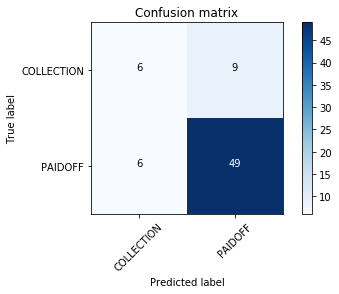

In [322]:
# k = 7 seems fine as it has maximum accuracy and Jaccard similarity scores
# Let's try to form a confusion matrix now
from sklearn.metrics import classification_report, confusion_matrix
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

    

X_train, X_test, y_train, y_test = train_test_split( X, y, test_size=0.2, random_state=4)
k = mean_acc.argmax()+1 # Optimal value as seen before
#Train Model and Predict  
neigh = KNeighborsClassifier(n_neighbors = k).fit(X_train,y_train)
y_test_predict = neigh.predict(X_test)
#print (y_test, y_test_predict, len(y_test[y_test==0]), len(y_test_predict[y_test_predict==0]))
# Compute confusion matrix
cnf_matrix = confusion_matrix(y_test, y_test_predict, labels=[1,0])
np.set_printoptions(precision=2)


# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=['COLLECTION', 'PAIDOFF'],normalize= False,  title='Confusion matrix')
print (classification_report(y_test, y_test_predict))

# Thus, there is higher accuracy in predicting PAIDOFFs (Individual who can pay given their features) than predicting COLLECTIONers.

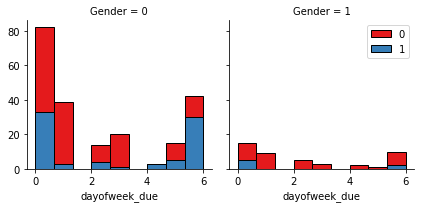

dayofweek_due  loan_status
0              0              0.718519
               1              0.281481
1              0              0.941176
               1              0.058824
2              0              0.826087
               1              0.173913
3              0              0.958333
               1              0.041667
4              0              0.625000
               1              0.375000
5              0              0.761905
               1              0.238095
6              0              0.619048
               1              0.380952
Name: loan_status, dtype: float64


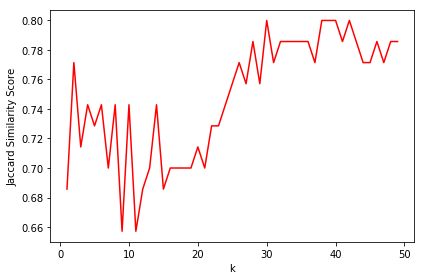

Jaccard Similarity Score is maximum at  30 with score= 0.8
Confusion matrix, without normalization
[[ 1 14]
 [ 0 55]]
             precision    recall  f1-score   support

          0       0.80      1.00      0.89        55
          1       1.00      0.07      0.12        15

avg / total       0.84      0.80      0.72        70



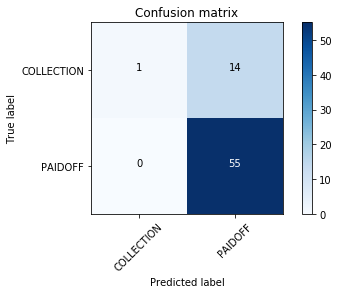

In [323]:
# Let's check if adding 'due-date' has any effect
df2 = df
df2['dayofweek_due'] = df2['due_date'].dt.dayofweek
bins = np.linspace(df2.dayofweek_due.min(), df2.dayofweek_due.max(), 10)
g = sns.FacetGrid(df2, col="Gender", hue="loan_status", palette="Set1", col_wrap=2)
g.map(plt.hist, 'dayofweek_due', bins=bins, ec="k")
g.axes[-1].legend()
plt.show()
print (df2.groupby(['dayofweek_due'])['loan_status'].value_counts(normalize=True))
# It seems that the PAIDOFF was higher during weekdays (so why ask to pay during the weekend?)

# Let's define weekdays
df2['weekday'] = df2['dayofweek_due'].apply(lambda x: 1 if ((x>0) & (x<6))  else 0)

# Let's define the Feature now
Feature2 = df2[['Principal','terms','age','Gender','weekend', 'weekday']]
Feature2 = pd.concat([Feature2,pd.get_dummies(df2['education'])], axis=1)
Feature2.drop(['Master or Above'], axis = 1,inplace=True)  # As there are just two people with masters (see by changing normalizing to False above)

# Preprocess the Feature
X1 = Feature2
X1= preprocessing.StandardScaler().fit(X1).transform(X1)

# Set the training and testing set
X_train, X_test, y_train, y_test = train_test_split( X1, y, test_size=0.2, random_state=4)

# Find the optimized k again
#Let's try few nearest neighbour values
Ks = 50
jac_similarity = np.zeros((Ks-1))
for n in range(1,Ks):
    neigh = KNeighborsClassifier(n_neighbors = n).fit(X_train,y_train)
    y_test_predict = neigh.predict(X_test)
    jac_similarity[n-1] = jaccard_similarity_score(y_test, y_test_predict)

# plot Jaccard Similarity Score
plt.plot(range(1,Ks),jac_similarity,'r')
plt.ylabel('Jaccard Similarity Score')
plt.xlabel('k')
plt.tight_layout()
plt.show()

print( "Jaccard Similarity Score is maximum at ", jac_similarity.argmax()+1, "with score=", jac_similarity.max())
# Thus the Jaccard Similarity Score increases with an extra feauture!
neigh = KNeighborsClassifier(n_neighbors = jac_similarity.argmax()+1).fit(X_train,y_train)
y_test_predict = neigh.predict(X_test)
# Let's see how confusion matrix looks now!
# First compute the predictions at optimized k

# Compute confusion matrix
cnf_matrix = confusion_matrix(y_test, y_test_predict, labels=[1,0])
np.set_printoptions(precision=2)
# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=['COLLECTION', 'PAIDOFF'],normalize= False,  title='Confusion matrix')
print (classification_report(y_test, y_test_predict))

# Conclusions from KNN
I showed two models with and without "due-date" feature.
The model with "due-date" included in the features has better Jaccard similarity score but it has a smaller f1-score.
As seen in the confusion matrix, this may give us high confidence prediction that which individuals are going to pay-off their loans by the due date.
However, as the f1-score is smaller, thus I'd have smaller confidence in this model than the previous one.
I'll do following exercise without "due-date feature".

# Decision Tree

In [324]:
from sklearn.tree import DecisionTreeClassifier
drugTree = DecisionTreeClassifier(criterion="entropy", max_depth = 8)
#drugTree # it shows the default parameters

# Preprocess the Feature
X = Feature
X= preprocessing.StandardScaler().fit(X).transform(X)

# Set the training and testing set
X_train, X_test, y_train, y_test = train_test_split( X, y, test_size=0.2, random_state=4)

#print (Feature[0:5]) # Shows our features
drugTree.fit(X_train,y_train)

# Let's get the prediction tree now
predTree = drugTree.predict(X_test)
print ('Predicted value by prediction tree: ', predTree [0:10])
print ('Real values from test data', y_test [0:10])

Predicted value by prediction tree:  [0 0 0 0 0 0 0 1 0 0]
Real values from test data [0 0 0 0 0 0 1 0 0 0]


Jaccard Similarity Score:  0.742857142857
Confusion matrix, without normalization
[[ 0 15]
 [ 3 52]]
             precision    recall  f1-score   support

          0       0.78      0.95      0.85        55
          1       0.00      0.00      0.00        15

avg / total       0.61      0.74      0.67        70



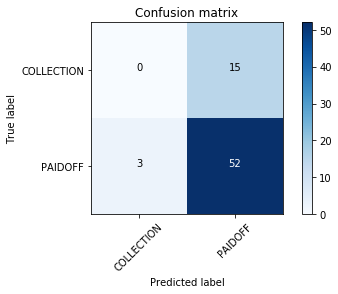

In [325]:
# Let's see the accuracy scores and confusion matrix again
print("Jaccard Similarity Score: ",jaccard_similarity_score(y_test, predTree))
# Compute confusion matrix
cnf_matrix = confusion_matrix(y_test, predTree, labels=[1,0])
np.set_printoptions(precision=2)
# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=['COLLECTION', 'PAIDOFF'],normalize= False,  title='Confusion matrix')
print (classification_report(y_test, predTree))

# Conclusions from Decision Tree
Decision tree seems to have smaller Jaccard similarity score as well as smaller f1-score as compared to the KNN.
Changing the max_depth parameter doesn't improve the accuracy for decision trees!

# Support Vector Machine

In [326]:
from sklearn import svm
clf = svm.SVC(kernel='rbf')  # Radial basis function
clf.fit(X_train, y_train)

SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)

In [327]:
yhat = clf.predict(X_test)
print ('Predicted value by prediction tree: ', yhat [0:10])
print ('Real values from test data', y_test [0:10])

Predicted value by prediction tree:  [1 0 0 0 0 0 1 1 0 0]
Real values from test data [0 0 0 0 0 0 1 0 0 0]


Jaccard Similarity Score:  0.742857142857
Confusion matrix, without normalization
[[ 4 11]
 [ 7 48]]
             precision    recall  f1-score   support

          0       0.81      0.87      0.84        55
          1       0.36      0.27      0.31        15

avg / total       0.72      0.74      0.73        70



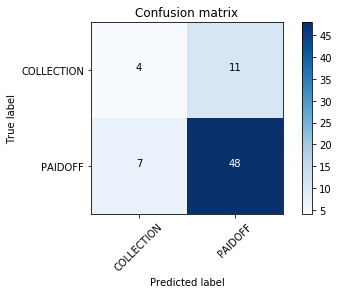

In [328]:
# Let's see the accuracy scores and confusion matrix again
print("Jaccard Similarity Score: ",jaccard_similarity_score(y_test, yhat))
# Compute confusion matrix
cnf_matrix = confusion_matrix(y_test, yhat, labels=[1,0])
np.set_printoptions(precision=2)
# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=['COLLECTION', 'PAIDOFF'],normalize= False,  title='Confusion matrix')
print (classification_report(y_test, yhat))

# Conclusions from SVM
Decision tree seems to have smaller Jaccard similarity score than KNN but f1-score is slightly better as compared to that from KNN.

# Logistic Regression

In [329]:
from sklearn.linear_model import LogisticRegression
LR = LogisticRegression(C=0.01, solver='liblinear').fit(X_train,y_train)
yhat = LR.predict(X_test)
yhat_prob = LR.predict_proba(X_test)
print ('Predicted value by Logistic regression: ', yhat [0:10])
print ('Real values from test data', y_test [0:10])

Predicted value by Logistic regression:  [1 0 0 0 0 0 0 0 0 0]
Real values from test data [0 0 0 0 0 0 1 0 0 0]


Jaccard Similarity Score:  0.685714285714
Confusion matrix, without normalization
[[ 2 13]
 [ 9 46]]
             precision    recall  f1-score   support

          0       0.78      0.84      0.81        55
          1       0.18      0.13      0.15        15

avg / total       0.65      0.69      0.67        70



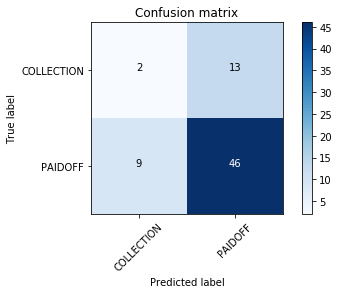

In [330]:
# Let's see the accuracy scores and confusion matrix again
print("Jaccard Similarity Score: ",jaccard_similarity_score(y_test, yhat))
# Compute confusion matrix
cnf_matrix = confusion_matrix(y_test, yhat, labels=[1,0])
np.set_printoptions(precision=2)
# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=['COLLECTION', 'PAIDOFF'],normalize= False,  title='Confusion matrix')
print (classification_report(y_test, yhat))


# Conclusions from Logistic Regression
LR seems to have smaller Jaccard similarity score as well as smaller f1-score as compared to the KNN.

# Model Evaluation using Test set

In [331]:
from sklearn.metrics import jaccard_similarity_score
from sklearn.metrics import f1_score
from sklearn.metrics import log_loss

First, download and load the test set:

In [283]:
!wget -O loan_test.csv https://s3-api.us-geo.objectstorage.softlayer.net/cf-courses-data/CognitiveClass/ML0101ENv3/labs/loan_test.csv

--2019-05-24 08:45:21--  https://s3-api.us-geo.objectstorage.softlayer.net/cf-courses-data/CognitiveClass/ML0101ENv3/labs/loan_test.csv
Resolving s3-api.us-geo.objectstorage.softlayer.net (s3-api.us-geo.objectstorage.softlayer.net)... 67.228.254.193
Connecting to s3-api.us-geo.objectstorage.softlayer.net (s3-api.us-geo.objectstorage.softlayer.net)|67.228.254.193|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 3642 (3.6K) [text/csv]
Saving to: ‘loan_test.csv’

100%[======================================>] 3,642       --.-K/s   in 0s      

2019-05-24 08:45:21 (622 MB/s) - ‘loan_test.csv’ saved [3642/3642]



### Load Test set for evaluation 

In [332]:
test_df = pd.read_csv('loan_test.csv')
test_df.head()

,Unnamed: 0,Unnamed: 0.1,loan_status,Principal,terms,effective_date,due_date,age,education,Gender
0,1,1,PAIDOFF,1000,30,9/8/2016,10/7/2016,50,Bechalor,female
1,5,5,PAIDOFF,300,7,9/9/2016,9/15/2016,35,Master or Above,male
2,21,21,PAIDOFF,1000,30,9/10/2016,10/9/2016,43,High School or Below,female
3,24,24,PAIDOFF,1000,30,9/10/2016,10/9/2016,26,college,male
4,35,35,PAIDOFF,800,15,9/11/2016,9/25/2016,29,Bechalor,male


In [333]:
# Prepare test data
test_df['due_date'] = pd.to_datetime(test_df['due_date'])
test_df['effective_date'] = pd.to_datetime(test_df['effective_date'])
test_df['dayofweek'] = test_df['effective_date'].dt.dayofweek
test_df['weekend'] = test_df['dayofweek'].apply(lambda x: 1 if (x>3)  else 0)
test_df['Gender'].replace(to_replace=['male','female'], value=[0,1],inplace=True)
test_df.head()

,Unnamed: 0,Unnamed: 0.1,loan_status,Principal,terms,effective_date,due_date,age,education,Gender,dayofweek,weekend
0,1,1,PAIDOFF,1000,30,2016-09-08,2016-10-07,50,Bechalor,1,3,0
1,5,5,PAIDOFF,300,7,2016-09-09,2016-09-15,35,Master or Above,0,4,1
2,21,21,PAIDOFF,1000,30,2016-09-10,2016-10-09,43,High School or Below,1,5,1
3,24,24,PAIDOFF,1000,30,2016-09-10,2016-10-09,26,college,0,5,1
4,35,35,PAIDOFF,800,15,2016-09-11,2016-09-25,29,Bechalor,0,6,1


In [334]:
Feature = test_df[['Principal','terms','age','Gender','weekend']]
Feature = pd.concat([Feature,pd.get_dummies(test_df['education'])], axis=1)
Feature.drop(['Master or Above'], axis = 1,inplace=True)
X2 = Feature
X2= preprocessing.StandardScaler().fit(X2).transform(X2)
Feature.head()

,Principal,terms,age,Gender,weekend,Bechalor,High School or Below,college
0,1000,30,50,1,0,1,0,0
1,300,7,35,0,1,0,0,0
2,1000,30,43,1,1,0,1,0
3,1000,30,26,0,1,0,0,1
4,800,15,29,0,1,1,0,0


In [335]:
test_df1 = test_df
test_df1.head()
test_df1['loan_status'].replace(to_replace=['PAIDOFF','COLLECTION'], value=[0,1],inplace=True)
y2 = test_df1['loan_status'].values

In [336]:
# KNN
X_train, X_test, y_train, y_test = train_test_split( X, y, test_size=0.2, random_state=4)
neigh = KNeighborsClassifier(n_neighbors = 7).fit(X_train,y_train)   # k = 7 as tested before (when due-date was not included)
y_test_predict = neigh.predict(X2)
print ('Jaccard SS =', jaccard_similarity_score(y2, y_test_predict))
print (classification_report(y2, y_test_predict))

Jaccard SS = 0.666666666667
             precision    recall  f1-score   support

          0       0.74      0.85      0.79        40
          1       0.25      0.14      0.18        14

avg / total       0.61      0.67      0.63        54



In [337]:
# Decision Tree
y_test_predict = drugTree.predict(X2)
print ('Jaccard SS =', jaccard_similarity_score(y2, y_test_predict))
print (classification_report(y2, y_test_predict))

Jaccard SS = 0.722222222222
             precision    recall  f1-score   support

          0       0.76      0.93      0.83        40
          1       0.40      0.14      0.21        14

avg / total       0.66      0.72      0.67        54



In [338]:
# SVM
y_test_predict = clf.predict(X2)
print ('Jaccard SS =', jaccard_similarity_score(y2, y_test_predict))
print (classification_report(y2, y_test_predict))

Jaccard SS = 0.796296296296
             precision    recall  f1-score   support

          0       0.80      0.97      0.88        40
          1       0.80      0.29      0.42        14

avg / total       0.80      0.80      0.76        54



In [340]:
# Logistic Regression
y_test_predict = LR.predict(X2)
y_test_prob = LR.predict_proba(X2)
print ('Jaccard SS =', jaccard_similarity_score(y2, y_test_predict))
print (classification_report(y2, y_test_predict))
print ('Log Loss =', log_loss(y2, y_test_prob))

Jaccard SS = 0.740740740741
             precision    recall  f1-score   support

          0       0.75      0.97      0.85        40
          1       0.50      0.07      0.12        14

avg / total       0.69      0.74      0.66        54

Log Loss = 0.567215337991


# Report
You should be able to report the accuracy of the built model using different evaluation metrics:

| Algorithm          | Jaccard | F1-score | LogLoss |
|--------------------|---------|----------|---------|
| KNN                | 0.66    | 0.63     | NA      |
| Decision Tree      | 0.72    | 0.67     | NA      |
| SVM                | 0.80    | 0.76     | NA      |
| LogisticRegression | 0.74    | 0.66     | 0.57    |

<h2>Want to learn more?</h2>

IBM SPSS Modeler is a comprehensive analytics platform that has many machine learning algorithms. It has been designed to bring predictive intelligence to decisions made by individuals, by groups, by systems – by your enterprise as a whole. A free trial is available through this course, available here: <a href="http://cocl.us/ML0101EN-SPSSModeler">SPSS Modeler</a>

Also, you can use Watson Studio to run these notebooks faster with bigger datasets. Watson Studio is IBM's leading cloud solution for data scientists, built by data scientists. With Jupyter notebooks, RStudio, Apache Spark and popular libraries pre-packaged in the cloud, Watson Studio enables data scientists to collaborate on their projects without having to install anything. Join the fast-growing community of Watson Studio users today with a free account at <a href="https://cocl.us/ML0101EN_DSX">Watson Studio</a>

<h3>Thanks for completing this lesson!</h3>

<h4>Author:  <a href="https://ca.linkedin.com/in/saeedaghabozorgi">Saeed Aghabozorgi</a></h4>
<p><a href="https://ca.linkedin.com/in/saeedaghabozorgi">Saeed Aghabozorgi</a>, PhD is a Data Scientist in IBM with a track record of developing enterprise level applications that substantially increases clients’ ability to turn data into actionable knowledge. He is a researcher in data mining field and expert in developing advanced analytic methods like machine learning and statistical modelling on large datasets.</p>

<hr>

<p>Copyright &copy; 2018 <a href="https://cocl.us/DX0108EN_CC">Cognitive Class</a>. This notebook and its source code are released under the terms of the <a href="https://bigdatauniversity.com/mit-license/">MIT License</a>.</p>